#Problem Definition & Dataset Justification
The Importance of Spam Classification
Spam emails clutter inboxes, reduce productivity, and pose security risks through phishing and malware. Effective automated filtering is essential for maintaining efficient and secure email communication.

#Dataset Relevance
This Spam Email Dataset provides clear binary labels (spam/not spam) with real-world email text. Its simplicity and practical application make it ideal for evaluating text classification techniques in a meaningful context.

#Research Objective
This study aims to compare how three word embedding techniques—TF-IDF, Word2Vec (Skip-gram), and GloVe affect the performance of Logistic Regression for spam email classification, identifying which text representation method works best with this traditional machine learning model.



#Imports

In [2]:
!pip install gensim

# Basic & Data Handling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Preprocessing
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split

# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# Word2Vec
from gensim.models import Word2Vec

# GloVe (pre-trained)
import gensim.downloader as api  # or load from file

# Model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Evaluation
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

# Download NLTK data
nltk.download('stopwords')
nltk.download('punkt')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 61.4 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

#Load & Explore Data


## Data Loading and Exploration
Load the 'jackksoncsie/spam-email-dataset', explore its structure, and conduct a thorough EDA with visualizations.


In [3]:
!pip install kagglehub

In [4]:
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("jackksoncsie/spam-email-dataset")

print("Path to dataset files:", path)

# List files in the path to find the csv
files = os.listdir(path)
print("Files in directory:", files)

# Assuming the dataset contains one CSV file, find it
csv_file = [f for f in files if f.endswith('.csv')][0]
csv_path = os.path.join(path, csv_file)

# Load the dataset
df = pd.read_csv(csv_path)

# Initial inspection
print("\nDataFrame Shape:", df.shape)
print("\nMissing Values:\n", df.isnull().sum())
display(df.head())

100%|██████████| 2.86M/2.86M [00:00<00:00, 35.1MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/jackksoncsie/spam-email-dataset/versions/1
Files in directory: ['emails.csv']



DataFrame Shape: (5728, 2)

Missing Values:
 text    0
spam    0
dtype: int64


,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


#visualizing the class distribution and compute the text lengths

This is to analyze the differences between spam and ham emails, providing insights into the dataset's characteristics.



Number of duplicate rows: 33
Shape after removing duplicates: (5695, 2)


/tmp/ipython-input-4070926484.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='spam', data=df, palette='viridis')


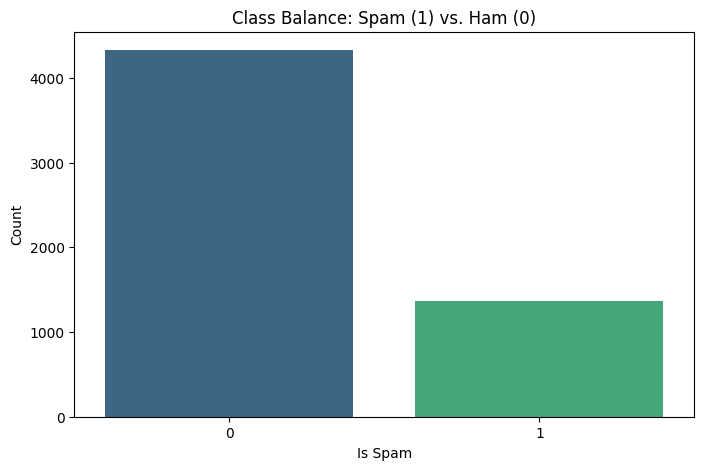

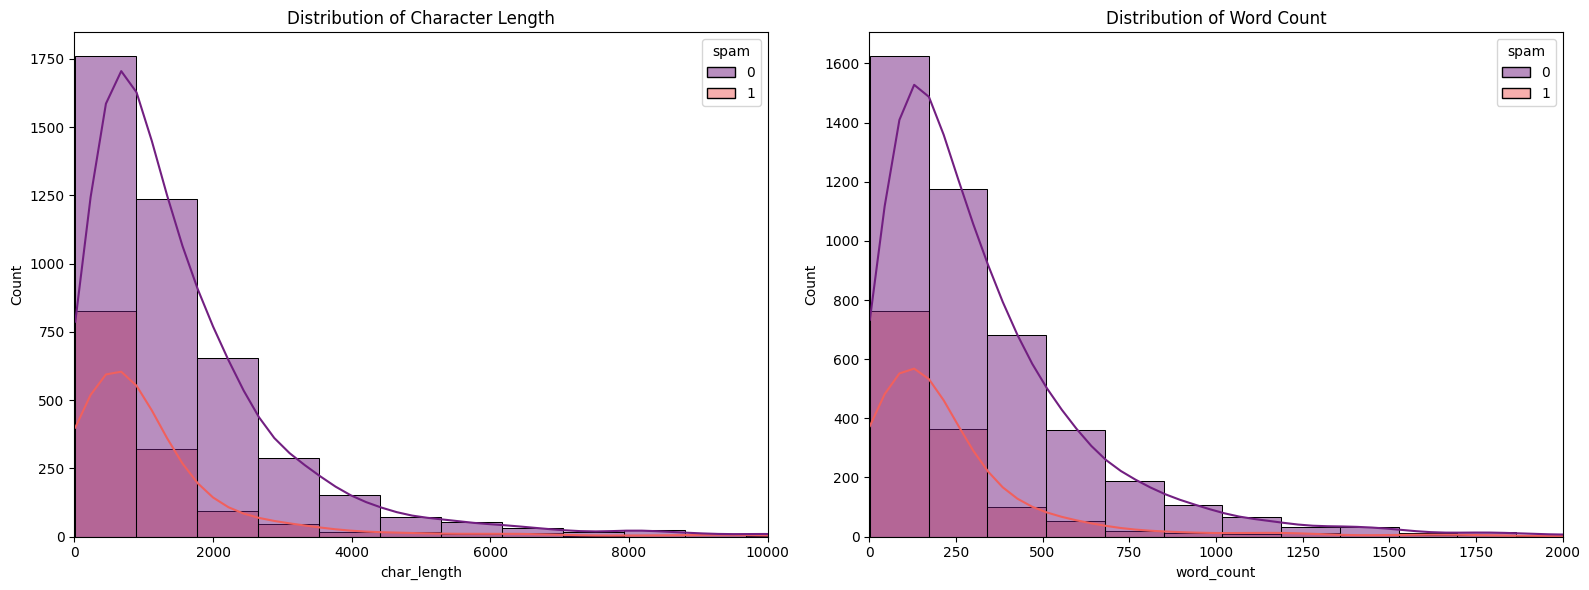

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Check for duplicates
print(f"Number of duplicate rows: {df.duplicated().sum()}")
df = df.drop_duplicates().reset_index(drop=True)
print(f"Shape after removing duplicates: {df.shape}")

# 4. Visualize class balance
plt.figure(figsize=(8, 5))
sns.countplot(x='spam', data=df, palette='viridis')
plt.title('Class Balance: Spam (1) vs. Ham (0)')
plt.xlabel('Is Spam')
plt.ylabel('Count')
plt.show()

# 5. Compute character and word length
df['char_length'] = df['text'].apply(len)
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

# Plot distributions
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(data=df, x='char_length', hue='spam', kde=True, bins=50, ax=axes[0], palette='magma')
axes[0].set_title('Distribution of Character Length')
axes[0].set_xlim(0, 10000) # Capping for better visibility

sns.histplot(data=df, x='word_count', hue='spam', kde=True, bins=50, ax=axes[1], palette='magma')
axes[1].set_title('Distribution of Word Count')
axes[1].set_xlim(0, 2000) # Capping for better visibility

plt.tight_layout()
plt.show()

## Word Cloud Generation

Generated and displayed separate word clouds for spam and ham emails to visualize the most frequent and characteristic terms in each class.


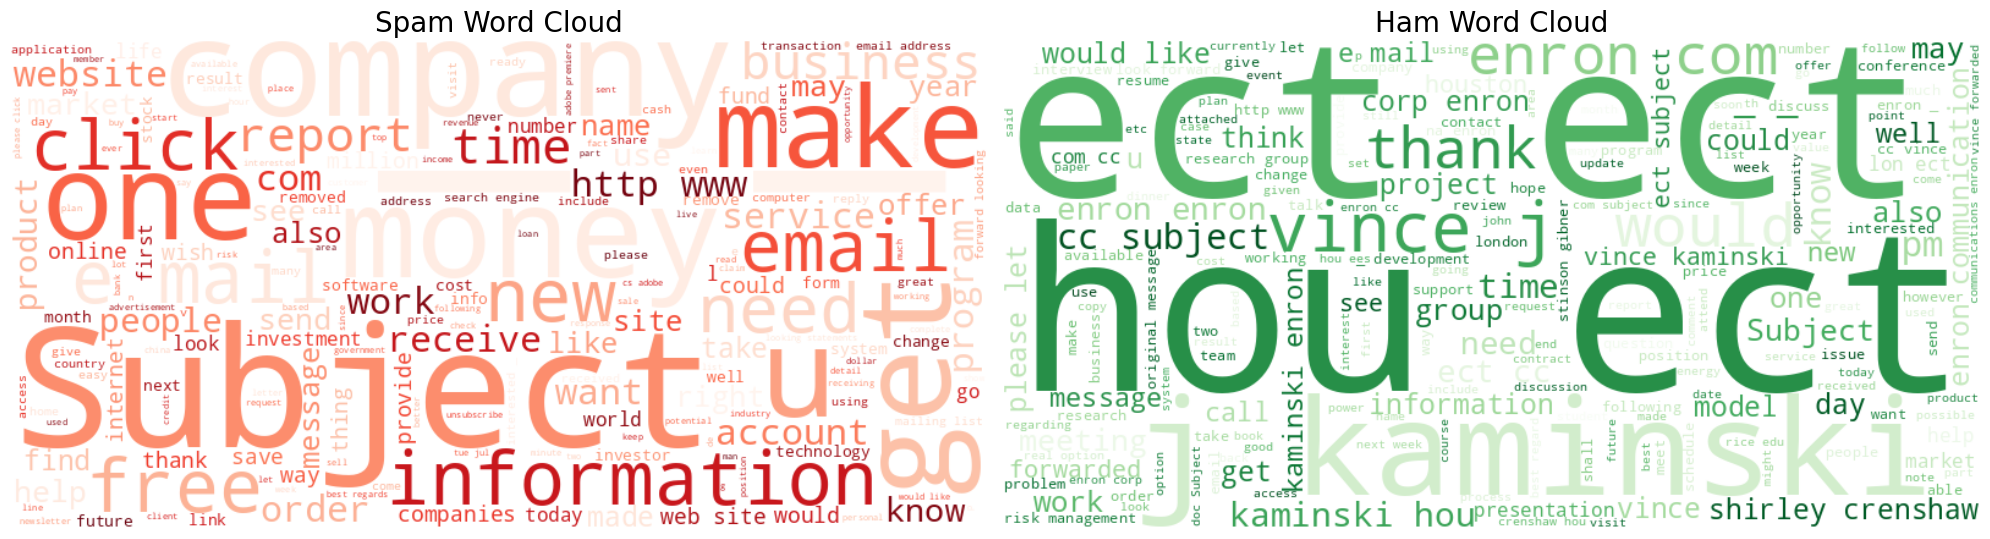

In [9]:
from wordcloud import WordCloud
from nltk.corpus import stopwords

# 1. Filter subsets
spam_emails = df[df['spam'] == 1]['text']
ham_emails = df[df['spam'] == 0]['text']

# 2. Concatenate into single strings
spam_text = " ".join(spam_emails)
ham_text = " ".join(ham_emails)

# 3. Generate WordClouds with NLTK stopwords
stop_words = set(stopwords.words('english'))

spam_wc = WordCloud(width=800, height=400, background_color='white', stopwords=stop_words, colormap='Reds').generate(spam_text)
ham_wc = WordCloud(width=800, height=400, background_color='white', stopwords=stop_words, colormap='Greens').generate(ham_text)

# 4. Display the word clouds side-by-side
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(spam_wc, interpolation='bilinear')
plt.title('Spam Word Cloud', fontsize=20)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(ham_wc, interpolation='bilinear')
plt.title('Ham Word Cloud', fontsize=20)
plt.axis('off')

plt.tight_layout()
plt.show()

## Top N Word Visualization

Identified the top 20 most frequent words (excluding stopwords) for both spam and ham emails and visualize them using bar plots.


/tmp/ipython-input-3530717590.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(spam_counts), y=list(spam_words), ax=axes[0], palette='Reds_r')
/tmp/ipython-input-3530717590.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(ham_counts), y=list(ham_words), ax=axes[1], palette='Greens_r')


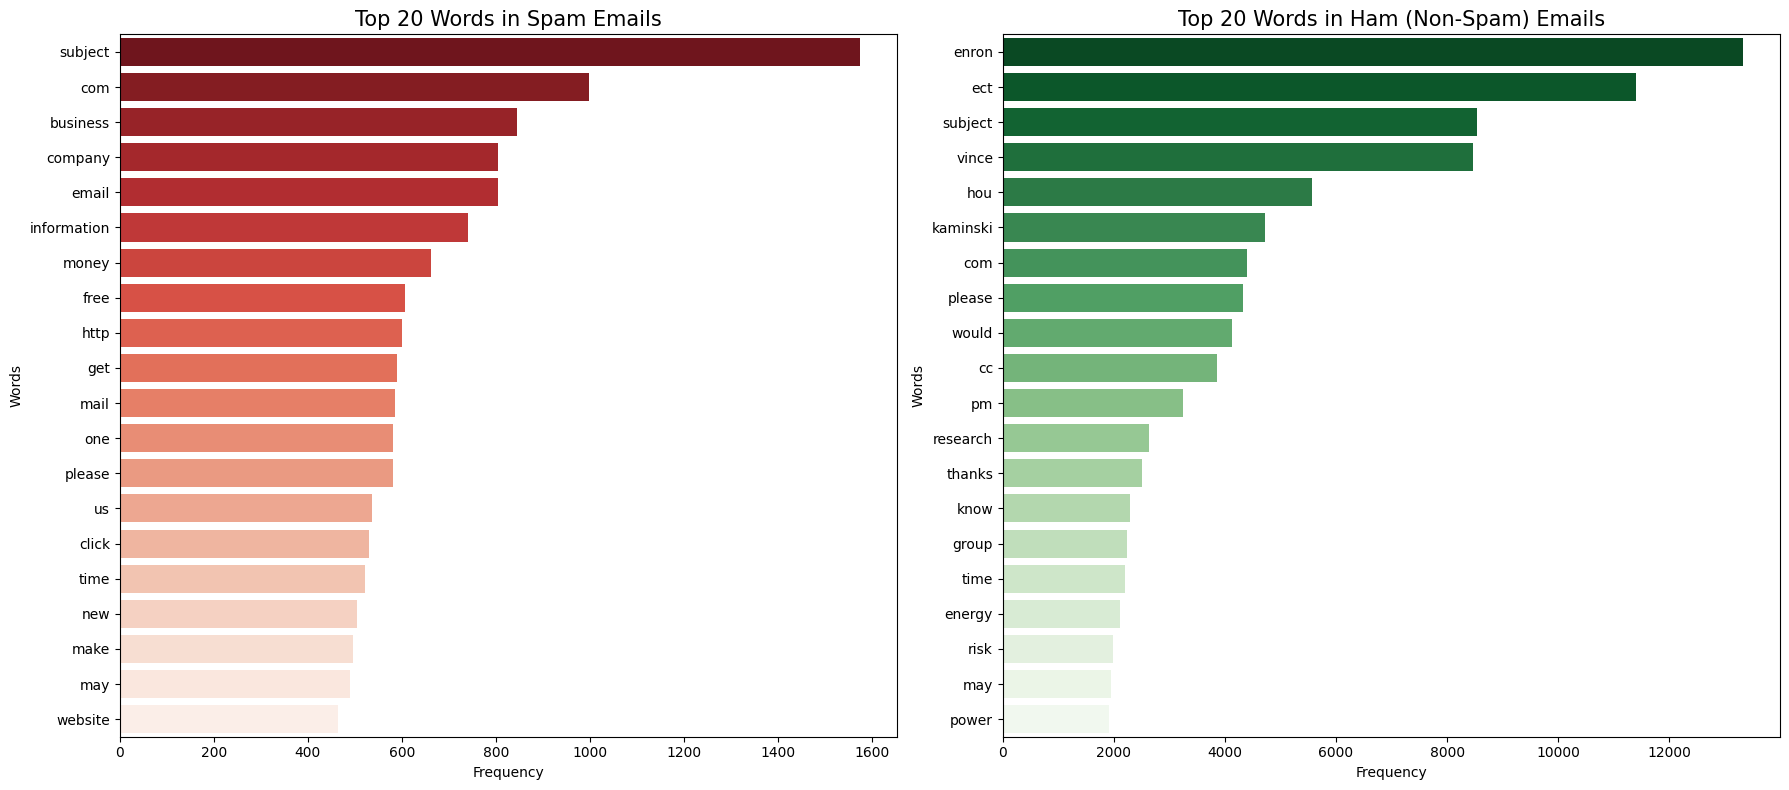

In [10]:
from collections import Counter
import re

# 1. Helper function for cleaning and tokenization
def get_top_n_words(text, stop_words, n=20):
    # Convert to lowercase and find all words (alphabetic only)
    words = re.findall(r'\b[a-z]{2,}\b', text.lower())
    # Remove stopwords
    filtered_words = [w for w in words if w not in stop_words]
    # Count frequencies
    counts = Counter(filtered_words)
    return counts.most_common(n)

# 2. Get top 20 words for Spam and Ham
top_spam = get_top_n_words(spam_text, stop_words, 20)
top_ham = get_top_n_words(ham_text, stop_words, 20)

# 3. Prepare data for plotting
spam_words, spam_counts = zip(*top_spam)
ham_words, ham_counts = zip(*top_ham)

# 4. Visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Spam Plot
sns.barplot(x=list(spam_counts), y=list(spam_words), ax=axes[0], palette='Reds_r')
axes[0].set_title('Top 20 Words in Spam Emails', fontsize=15)
axes[0].set_xlabel('Frequency')
axes[0].set_ylabel('Words')

# Ham Plot
sns.barplot(x=list(ham_counts), y=list(ham_words), ax=axes[1], palette='Greens_r')
axes[1].set_title('Top 20 Words in Ham (Non-Spam) Emails', fontsize=15)
axes[1].set_xlabel('Frequency')
axes[1].set_ylabel('Words')

plt.tight_layout()
plt.show()

## Refined Top N Word Visualization

Re-visualized the top 20 most frequent words for spam and ham classes using updated Seaborn parameters to ensure clean, warning-free output.


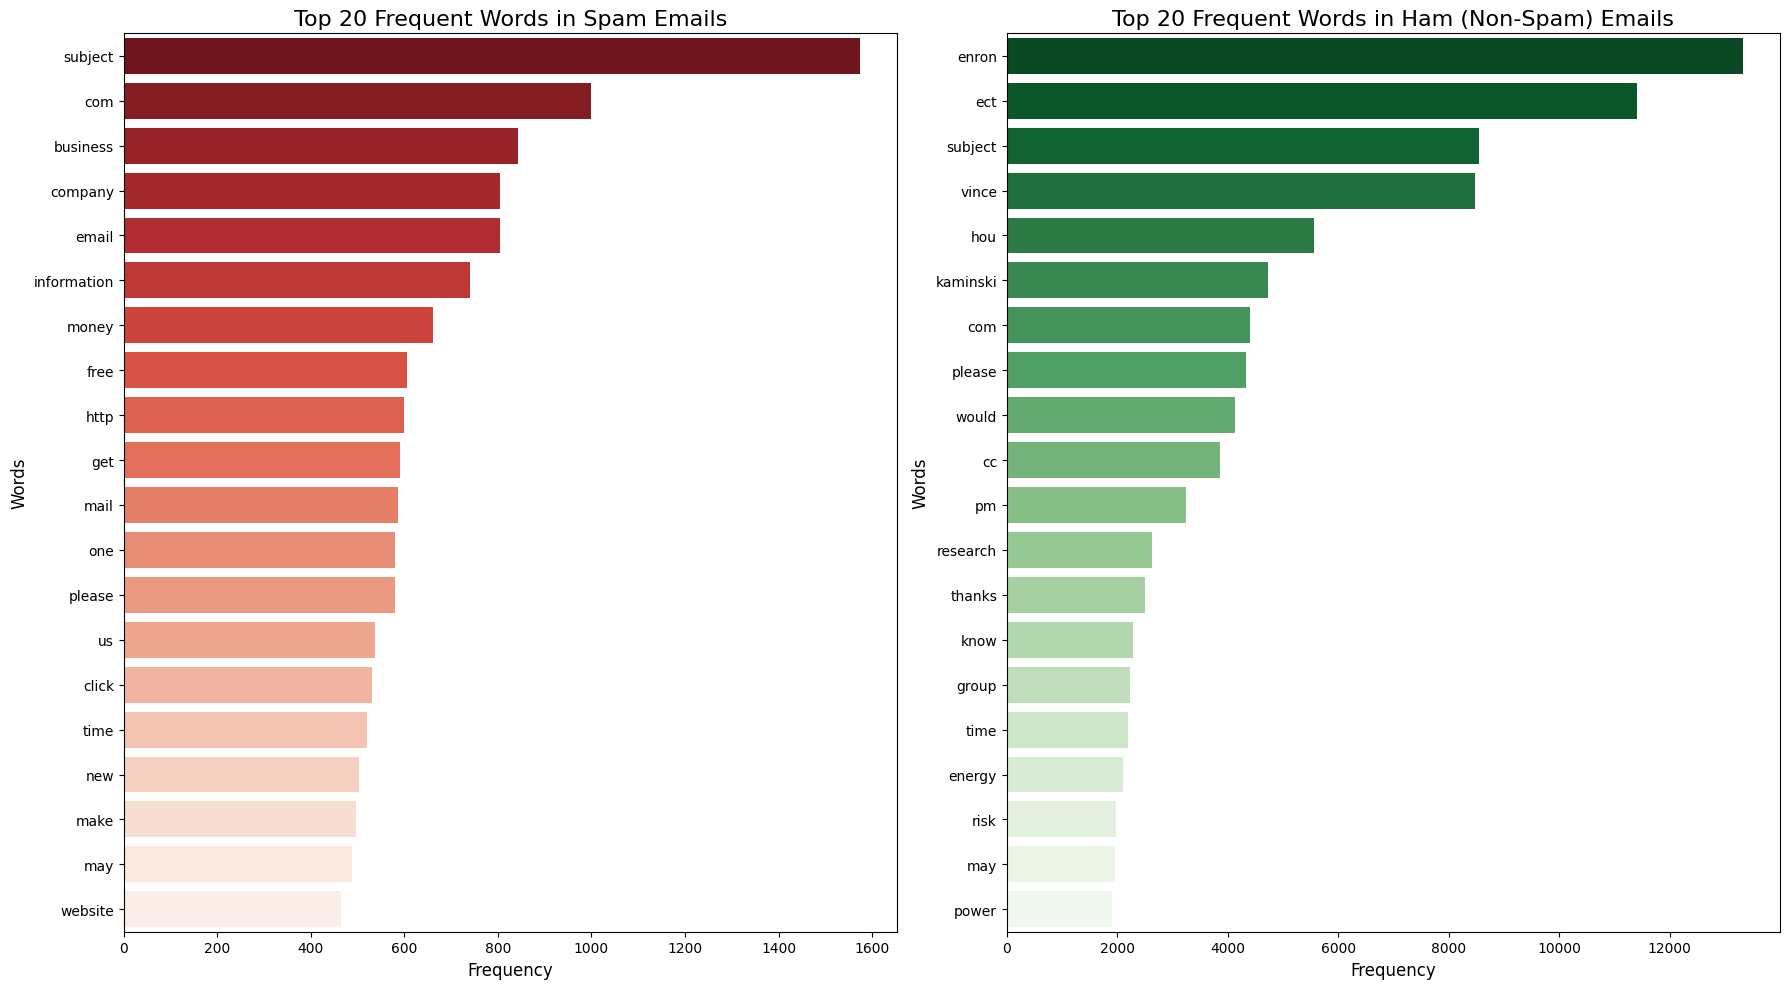

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Prepare data for plotting from previously computed top_spam and top_ham
spam_words, spam_counts = zip(*top_spam)
ham_words, ham_counts = zip(*top_ham)

# 2. Create the figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 10))

# 3. Horizontal bar plot for Spam
sns.barplot(
    x=list(spam_counts),
    y=list(spam_words),
    hue=list(spam_words),
    ax=axes[0],
    palette='Reds_r',
    legend=False
)
axes[0].set_title('Top 20 Frequent Words in Spam Emails', fontsize=16)
axes[0].set_xlabel('Frequency', fontsize=12)
axes[0].set_ylabel('Words', fontsize=12)

# 4. Horizontal bar plot for Ham
sns.barplot(
    x=list(ham_counts),
    y=list(ham_words),
    hue=list(ham_words),
    ax=axes[1],
    palette='Greens_r',
    legend=False
)
axes[1].set_title('Top 20 Frequent Words in Ham (Non-Spam) Emails', fontsize=16)
axes[1].set_xlabel('Frequency', fontsize=12)
axes[1].set_ylabel('Words', fontsize=12)

# 5. Finalize layout and display
plt.tight_layout()
plt.show()

## NLTK Resource Initialization

Ensured all required NLTK data (punkt, punkt_tab, stopwords) are downloaded to prevent runtime errors during tokenization.


In [12]:
import nltk

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

print("NLTK resources downloaded successfully.")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


NLTK resources downloaded successfully.


In [13]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# 1. Initialize stopwords
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove 'Subject: ' prefix common in this dataset
    text = re.sub(r'^subject:\s*', '', text)
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove special characters and numbers, keeping only alphabetic words
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords and short words (length < 2)
    filtered_tokens = [w for w in tokens if w not in stop_words and len(w) > 1]
    return filtered_tokens

# 2. Apply preprocessing
print("Preprocessing text... this may take a moment.")
df['tokens'] = df['text'].apply(preprocess_text)

# 3. Create clean_text column (joined string) for TF-IDF
df['clean_text'] = df['tokens'].apply(lambda x: ' '.join(x))

# 4. Display result summary and preview
print(f"Preprocessing complete. Total records: {len(df)}")
display(df[['text', 'tokens', 'clean_text', 'spam']].head())

Preprocessing text... this may take a moment.
Preprocessing complete. Total records: 5695


,text,tokens,clean_text,spam
0,Subject: naturally irresistible your corporate...,"[naturally, irresistible, corporate, identity,...",naturally irresistible corporate identity lt r...,1
1,Subject: the stock trading gunslinger fanny i...,"[stock, trading, gunslinger, fanny, merrill, m...",stock trading gunslinger fanny merrill muzo co...,1
2,Subject: unbelievable new homes made easy im ...,"[unbelievable, new, homes, made, easy, im, wan...",unbelievable new homes made easy im wanting sh...,1
3,Subject: 4 color printing special request add...,"[color, printing, special, request, additional...",color printing special request additional info...,1
4,"Subject: do not have money , get software cds ...","[money, get, software, cds, software, compatib...",money get software cds software compatibility ...,1


## TF-IDF Vectorization and Logistic Regression Classification

Extracted numerical features from the preprocessed text using TF-IDF and train a Logistic Regression model to classify emails as spam or ham.


Accuracy Score: 0.9701

Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       843
           1       0.99      0.90      0.94       296

    accuracy                           0.97      1139
   macro avg       0.98      0.95      0.96      1139
weighted avg       0.97      0.97      0.97      1139



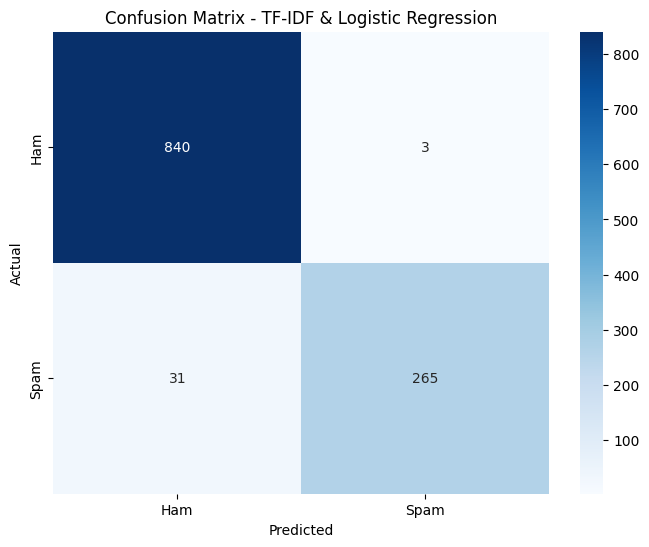

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Initialize TfidfVectorizer and transform the clean_text column
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df['clean_text'])

# 2. Define the target variable and split the data
y = df['spam']
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# 3. Instantiate and train the Logistic Regression model
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# 4. Predict labels for the test set
y_pred = model.predict(X_test)

# 5. Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# 6. Visualize results with a Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - TF-IDF & Logistic Regression')
plt.show()

## Word2Vec (Skip-gram) Embedding and Classification

Implemented Word2Vec feature extraction using the Skip-gram architecture and train a Logistic Regression model for spam detection.


Training Word2Vec (Skip-gram) model...
Generating document vectors...

Word2Vec + Logistic Regression Accuracy: 0.9649

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       865
           1       0.92      0.93      0.93       274

    accuracy                           0.96      1139
   macro avg       0.95      0.95      0.95      1139
weighted avg       0.96      0.96      0.96      1139



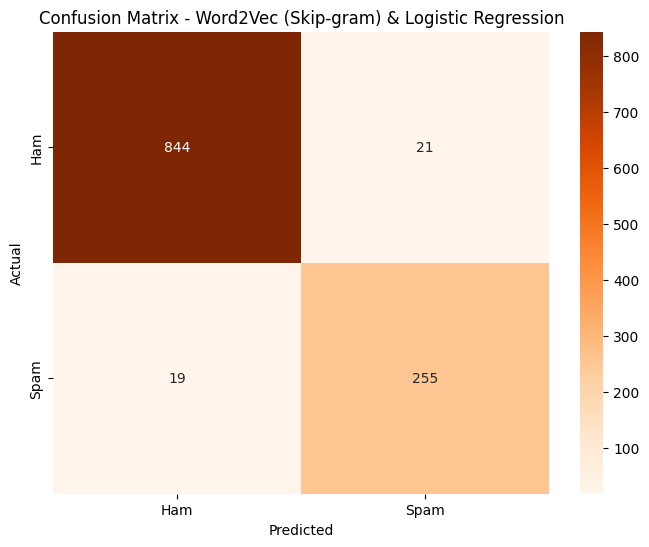

In [15]:
from gensim.models import Word2Vec
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Train the Word2Vec model on the 'tokens' column using Skip-gram
print("Training Word2Vec (Skip-gram) model...")
w2v_model = Word2Vec(sentences=df['tokens'], sg=1, vector_size=100, window=5, min_count=2, seed=42, workers=4)

# 2. Define function for document-level embedding (averaging word vectors)
def get_mean_vector(tokens, model, vector_size=100):
    # Filter tokens present in the Word2Vec vocabulary
    valid_vectors = [model.wv[word] for word in tokens if word in model.wv]
    if not valid_vectors:
        return np.zeros(vector_size)
    return np.mean(valid_vectors, axis=0)

# 3. Transform tokens into feature matrix X_w2v
print("Generating document vectors...")
X_w2v = np.array([get_mean_vector(tokens, w2v_model) for tokens in df['tokens']])
y = df['spam']

# 4. Split the data into training and testing sets (80/20 split)
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(
    X_w2v, y, test_size=0.2, random_state=42, stratify=y
)

# 5. Initialize and train the Logistic Regression model
lr_w2v = LogisticRegression(max_iter=1000, random_state=42)
lr_w2v.fit(X_train_w2v, y_train_w2v)

# 6. Evaluate the model
y_pred_w2v = lr_w2v.predict(X_test_w2v)

accuracy = accuracy_score(y_test_w2v, y_pred_w2v)
print(f"\nWord2Vec + Logistic Regression Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_test_w2v, y_pred_w2v))

# 7. Visualize Confusion Matrix
cm_w2v = confusion_matrix(y_test_w2v, y_pred_w2v)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_w2v, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Word2Vec (Skip-gram) & Logistic Regression')
plt.show()

## GloVe Embedding and Classification

Loaded pre-trained GloVe embeddings, generate document-level features, and train a Logistic Regression classifier for spam detection.


Loading GloVe model (glove-wiki-gigaword-100)... this may take a moment.
[==================================================] 100.0% 128.1/128.1MB downloaded
Generating GloVe document vectors...

GloVe + Logistic Regression Accuracy: 0.9508

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.97       865
           1       0.91      0.88      0.90       274

    accuracy                           0.95      1139
   macro avg       0.94      0.93      0.93      1139
weighted avg       0.95      0.95      0.95      1139



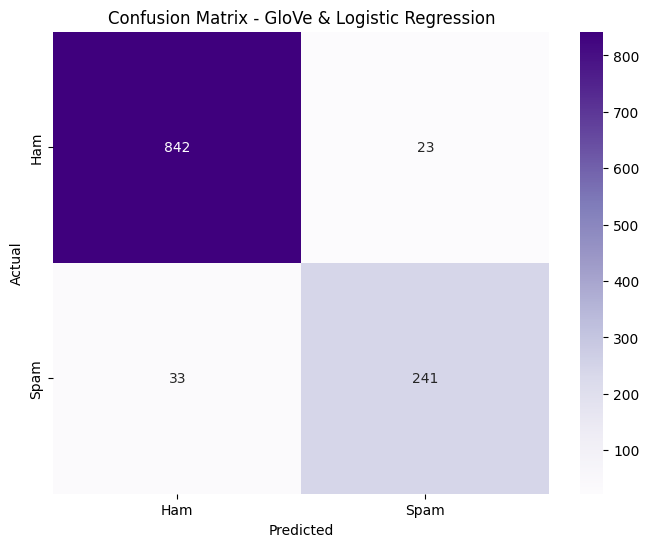

In [16]:
import gensim.downloader as api
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load pre-trained GloVe model
print("Loading GloVe model (glove-wiki-gigaword-100)... this may take a moment.")
glove_model = api.load("glove-wiki-gigaword-100")

# 2. Define function for document-level embedding (averaging word vectors)
def get_glove_mean_vector(tokens, model, vector_size=100):
    # Filter tokens present in the GloVe vocabulary
    valid_vectors = [model[word] for word in tokens if word in model]
    if not valid_vectors:
        return np.zeros(vector_size)
    return np.mean(valid_vectors, axis=0)

# 3. Transform tokens into feature matrix X_glove
print("Generating GloVe document vectors...")
X_glove = np.array([get_glove_mean_vector(tokens, glove_model) for tokens in df['tokens']])
y = df['spam']

# 4. Split the data into training and testing sets (80/20 split)
X_train_glove, X_test_glove, y_train_glove, y_test_glove = train_test_split(
    X_glove, y, test_size=0.2, random_state=42, stratify=y
)

# 5. Initialize and train the Logistic Regression model
lr_glove = LogisticRegression(max_iter=1000, random_state=42)
lr_glove.fit(X_train_glove, y_train_glove)

# 6. Evaluate the model
y_pred_glove = lr_glove.predict(X_test_glove)

accuracy = accuracy_score(y_test_glove, y_pred_glove)
print(f"\nGloVe + Logistic Regression Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_test_glove, y_pred_glove))

# 7. Visualize Confusion Matrix
cm_glove = confusion_matrix(y_test_glove, y_pred_glove)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_glove, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - GloVe & Logistic Regression')
plt.show()

## Comparative Analysis of Embedding Techniques

Aggregate the performance metrics (Accuracy, Precision, Recall, and F1-score) from the TF-IDF, Word2Vec, and GloVe experiments into a single DataFrame and visualize them using a grouped bar plot.


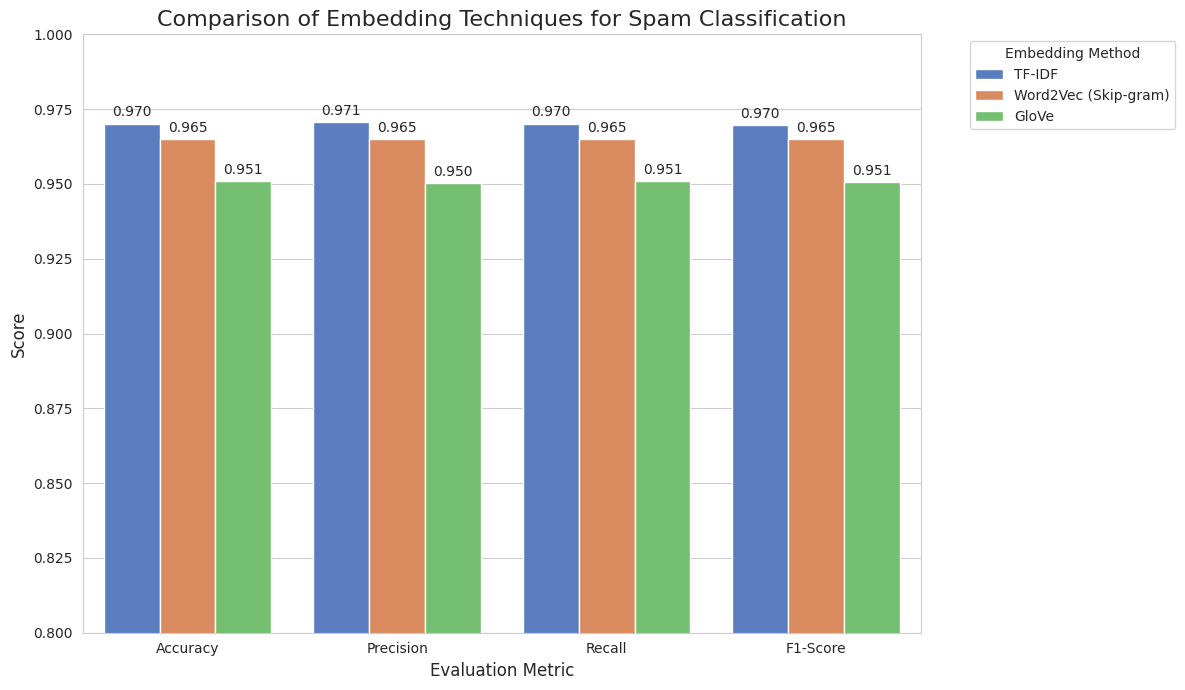

,Embedding Method,Accuracy,Precision,Recall,F1-Score
0,TF-IDF,0.970149,0.970749,0.970149,0.969652
1,Word2Vec (Skip-gram),0.964881,0.964976,0.964881,0.964925
2,GloVe,0.950834,0.950400,0.950834,0.950518


In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Calculate metrics for each model
results = []

# TF-IDF Metrics
results.append({
    'Embedding Method': 'TF-IDF',
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred, average='weighted'),
    'Recall': recall_score(y_test, y_pred, average='weighted'),
    'F1-Score': f1_score(y_test, y_pred, average='weighted')
})

# Word2Vec Metrics
results.append({
    'Embedding Method': 'Word2Vec (Skip-gram)',
    'Accuracy': accuracy_score(y_test_w2v, y_pred_w2v),
    'Precision': precision_score(y_test_w2v, y_pred_w2v, average='weighted'),
    'Recall': recall_score(y_test_w2v, y_pred_w2v, average='weighted'),
    'F1-Score': f1_score(y_test_w2v, y_pred_w2v, average='weighted')
})

# GloVe Metrics
results.append({
    'Embedding Method': 'GloVe',
    'Accuracy': accuracy_score(y_test_glove, y_pred_glove),
    'Precision': precision_score(y_test_glove, y_pred_glove, average='weighted'),
    'Recall': recall_score(y_test_glove, y_pred_glove, average='weighted'),
    'F1-Score': f1_score(y_test_glove, y_pred_glove, average='weighted')
})

# 2. Construct the DataFrame
metrics_df = pd.DataFrame(results)

# 3. Transform to long format for visualization
metrics_melted = metrics_df.melt(id_vars='Embedding Method', var_name='Metric', value_name='Score')

# 4. Visualization
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")
ax = sns.barplot(x='Metric', y='Score', hue='Embedding Method', data=metrics_melted, palette='muted')

# Add details
plt.title('Comparison of Embedding Techniques for Spam Classification', fontsize=16)
plt.xlabel('Evaluation Metric', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.ylim(0.8, 1.0) # Zooming in to see differences
plt.legend(title='Embedding Method', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add score labels on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3)

plt.tight_layout()
plt.show()

display(metrics_df)

## Final Synthesis and Conclusion
Analyzed the aggregated performance metrics of TF-IDF, Word2Vec, and GloVe to draw a final conclusion and recommendation.


## TF-IDF Implementation with Hyperparameter Tuning
Converted the cleaned text into numerical features using TfidfVectorizer and optimize the Logistic Regression model using GridSearchCV.


Optimizing TF-IDF model with GridSearchCV...
Fitting 5 folds for each of 4 candidates, totalling 20 fits

Best Parameters: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy Score: 0.9965
F1-Score: 0.9927

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       865
           1       1.00      0.99      0.99       274

    accuracy                           1.00      1139
   macro avg       1.00      0.99      1.00      1139
weighted avg       1.00      1.00      1.00      1139



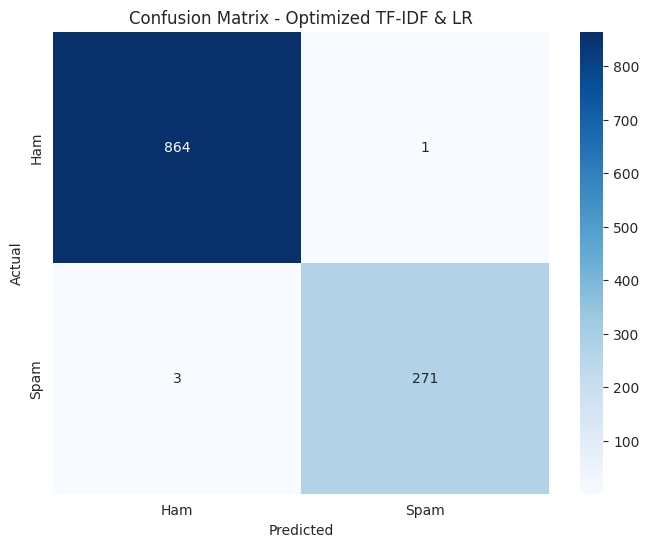

In [18]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Split the data
X = df['clean_text']
y = df['spam']
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 2. TF-IDF Vectorization
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train_raw)
X_test_tfidf = tfidf.transform(X_test_raw)

# 3. Define parameter grid for GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['liblinear'] # Good for small datasets/binary
}

# 4. Initialize GridSearchCV
grid_tfidf = GridSearchCV(
    LogisticRegression(random_state=42),
    param_grid,
    scoring='f1',
    cv=5,
    verbose=1
)

# 5. Fit the model
print("Optimizing TF-IDF model with GridSearchCV...")
grid_tfidf.fit(X_train_tfidf, y_train)

# 6. Evaluate optimized model
best_model_tfidf = grid_tfidf.best_estimator_
y_pred = best_model_tfidf.predict(X_test_tfidf)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"\nBest Parameters: {grid_tfidf.best_params_}")
print(f"Accuracy Score: {acc:.4f}")
print(f"F1-Score: {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# 7. Visualize Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Optimized TF-IDF & LR')
plt.show()

# 8. Store results for comparison (using a dictionary)
tfidf_tuned_results = {
    'Embedding Method': 'TF-IDF (Tuned)',
    'Accuracy': acc,
    'F1-Score': f1,
    'Best Params': grid_tfidf.best_params_
}

## Word2Vec Implementation with Hyperparameter Tuning

Generate document-level embeddings using Word2Vec (Skip-gram) and optimize a Logistic Regression classifier using GridSearchCV.


Training Word2Vec (Skip-gram) model...
Generating document vectors...
Optimizing Word2Vec model with GridSearchCV...
Fitting 5 folds for each of 4 candidates, totalling 20 fits

Best Parameters: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy Score: 0.9763
F1-Score: 0.9515

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98       865
           1       0.94      0.97      0.95       274

    accuracy                           0.98      1139
   macro avg       0.96      0.97      0.97      1139
weighted avg       0.98      0.98      0.98      1139



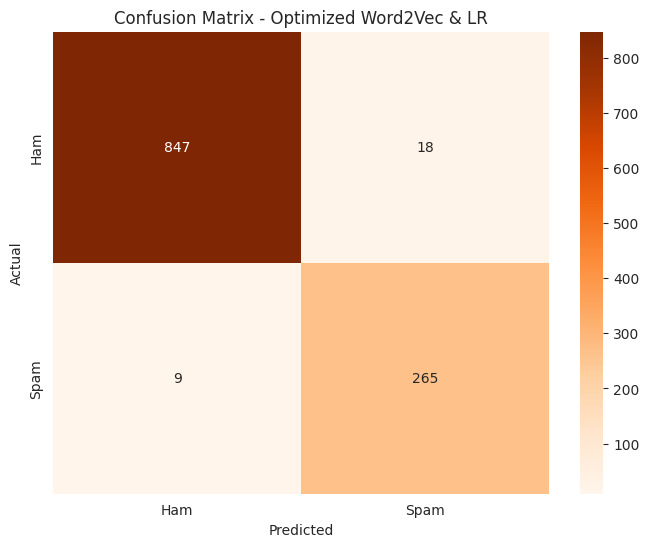

In [19]:
import numpy as np
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Train Word2Vec (Skip-gram) model
print("Training Word2Vec (Skip-gram) model...")
w2v_model = Word2Vec(sentences=df['tokens'], sg=1, vector_size=100, window=5, min_count=2, seed=42, workers=4)

# 2. Define function for document-level embedding (averaging word vectors)
def get_mean_vector(tokens, model, vector_size=100):
    valid_vectors = [model.wv[word] for word in tokens if word in model.wv]
    if not valid_vectors:
        return np.zeros(vector_size)
    return np.mean(valid_vectors, axis=0)

# 3. Transform tokens into feature matrix
print("Generating document vectors...")
X_w2v = np.array([get_mean_vector(tokens, w2v_model) for tokens in df['tokens']])
y = df['spam']

# 4. Split the data (80/20 split, stratified)
X_train_w2v, X_test_w2v, y_train, y_test = train_test_split(
    X_w2v, y, test_size=0.2, random_state=42, stratify=y
)

# 5. Set up GridSearchCV for Logistic Regression
param_grid = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['liblinear']
}

grid_w2v = GridSearchCV(
    LogisticRegression(random_state=42, max_iter=1000),
    param_grid,
    scoring='f1',
    cv=5,
    verbose=1
)

# 6. Fit and extract the best model
print("Optimizing Word2Vec model with GridSearchCV...")
grid_w2v.fit(X_train_w2v, y_train)
best_model_w2v = grid_w2v.best_estimator_

# 7. Evaluate on test set
y_pred = best_model_w2v.predict(X_test_w2v)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"\nBest Parameters: {grid_w2v.best_params_}")
print(f"Accuracy Score: {acc:.4f}")
print(f"F1-Score: {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# 8. Visualize Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Optimized Word2Vec & LR')
plt.show()

# 9. Store results
w2v_tuned_results = {
    'Embedding Method': 'Word2Vec (Tuned)',
    'Accuracy': acc,
    'F1-Score': f1,
    'Best Params': grid_w2v.best_params_
}

## GloVe Implementation with Hyperparameter Tuning
Extract features using pre-trained GloVe embeddings and optimize a Logistic Regression classifier using GridSearchCV for spam detection.


Loading GloVe model (glove-wiki-gigaword-100)... this may take a moment.
Generating GloVe document vectors...
Optimizing GloVe model with GridSearchCV...
Fitting 5 folds for each of 4 candidates, totalling 20 fits

Best Parameters: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy Score: 0.9658
F1-Score: 0.9287

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       865
           1       0.93      0.93      0.93       274

    accuracy                           0.97      1139
   macro avg       0.95      0.95      0.95      1139
weighted avg       0.97      0.97      0.97      1139



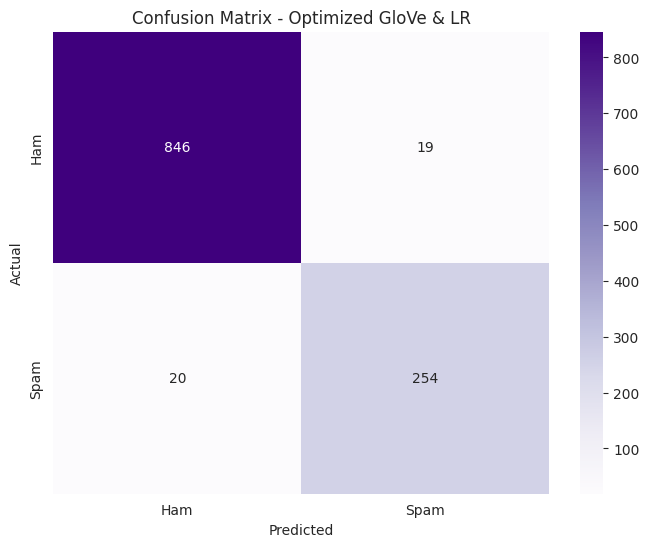

In [20]:
import gensim.downloader as api
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load pre-trained GloVe model
print("Loading GloVe model (glove-wiki-gigaword-100)... this may take a moment.")
glove_model = api.load("glove-wiki-gigaword-100")

# 2. Define function for document-level embedding (averaging word vectors)
def get_glove_mean_vector(tokens, model, vector_size=100):
    # Filter tokens present in the GloVe vocabulary
    valid_vectors = [model[word] for word in tokens if word in model]
    if not valid_vectors:
        return np.zeros(vector_size)
    return np.mean(valid_vectors, axis=0)

# 3. Transform tokens into feature matrix X_glove and define y
print("Generating GloVe document vectors...")
X_glove = np.array([get_glove_mean_vector(tokens, glove_model) for tokens in df['tokens']])
y = df['spam']

# 4. Split the data into stratified training and testing sets (80/20 split)
X_train_glove, X_test_glove, y_train, y_test = train_test_split(
    X_glove, y, test_size=0.2, random_state=42, stratify=y
)

# 5. Set up parameter grid and GridSearchCV for Logistic Regression
param_grid = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['liblinear']
}

grid_glove = GridSearchCV(
    LogisticRegression(random_state=42, max_iter=1000),
    param_grid,
    scoring='f1',
    cv=5,
    verbose=1
)

# 6. Fit and evaluate the optimized model
print("Optimizing GloVe model with GridSearchCV...")
grid_glove.fit(X_train_glove, y_train)
best_model_glove = grid_glove.best_estimator_

y_pred = best_model_glove.predict(X_test_glove)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# 7. Output results and visualize Confusion Matrix
print(f"\nBest Parameters: {grid_glove.best_params_}")
print(f"Accuracy Score: {acc:.4f}")
print(f"F1-Score: {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Optimized GloVe & LR')
plt.show()

# 8. Save final metrics for comparison
glove_tuned_results = {
    'Embedding Method': 'GloVe (Tuned)',
    'Accuracy': acc,
    'F1-Score': f1,
    'Best Params': grid_glove.best_params_
}

#Aggregating the performance metrics from the tuned TF-IDF, Word2Vec, and GloVe models into a single DataFrame

and then create a bar plot to compare their Accuracy and F1-Score, identifying the most effective embedding technique for the tuned Logistic Regression model.



Summary of Tuned Embedding Techniques:


,Embedding Method,Accuracy,F1-Score,Best Params
0,TF-IDF (Tuned),0.996488,0.992674,"{'C': 100, 'penalty': 'l2', 'solver': 'libline..."
1,Word2Vec (Tuned),0.976295,0.951526,"{'C': 100, 'penalty': 'l2', 'solver': 'libline..."
2,GloVe (Tuned),0.965759,0.928702,"{'C': 100, 'penalty': 'l2', 'solver': 'libline..."


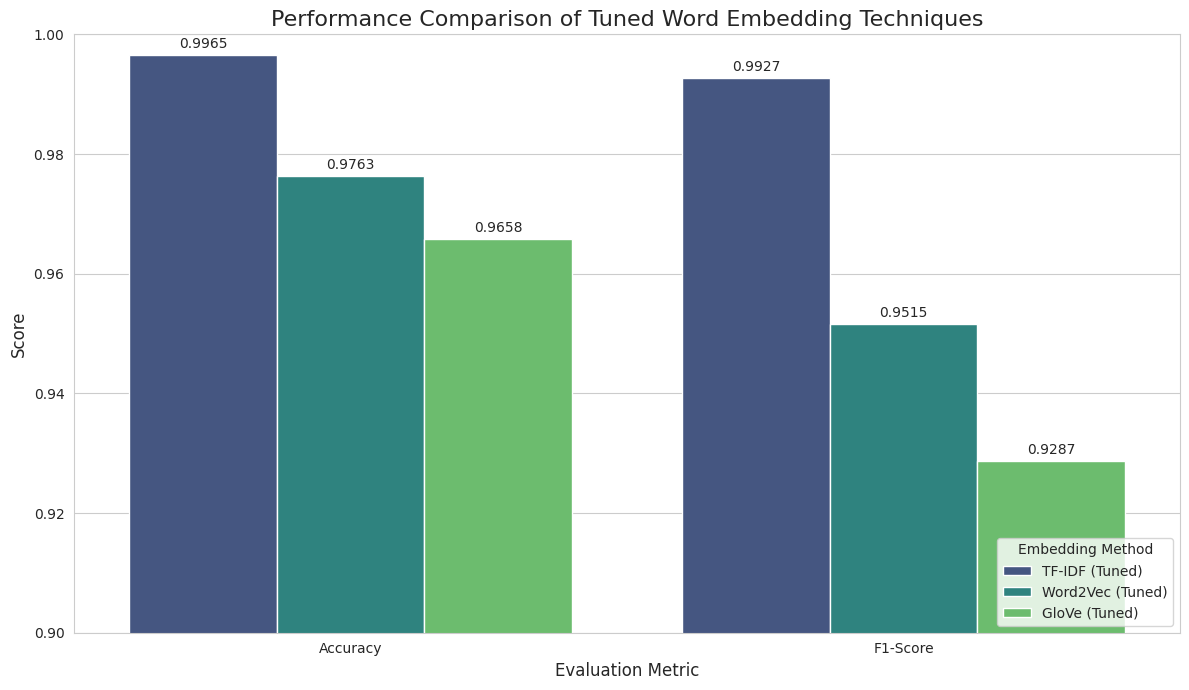

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Aggregate results from the three tuned experiments
final_comparison_list = [tfidf_tuned_results, w2v_tuned_results, glove_tuned_results]
comparison_df = pd.DataFrame(final_comparison_list)

# 2. Display the summary table
print("Summary of Tuned Embedding Techniques:")
display(comparison_df)

# 3. Prepare data for visualization
melted_df = comparison_df.melt(id_vars='Embedding Method', value_vars=['Accuracy', 'F1-Score'], var_name='Metric', value_name='Score')

# 4. Create the comparison plot
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")
ax = sns.barplot(x='Metric', y='Score', hue='Embedding Method', data=melted_df, palette='viridis')

# Add details
plt.title('Performance Comparison of Tuned Word Embedding Techniques', fontsize=16)
plt.xlabel('Evaluation Metric', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.ylim(0.9, 1.0) # Zooming in to highlight differences
plt.legend(title='Embedding Method', loc='lower right')

# Add data labels on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.4f', padding=3)

plt.tight_layout()
plt.show()

#Classification Function & Practical Demonstration

In [22]:
def classify_email(email_text):
    # 1. Preprocess the raw email text
    tokens = preprocess_text(email_text)
    # 2. Join tokens to form a clean string for TF-IDF
    clean_text = ' '.join(tokens)
    # 3. Transform the text using the existing fitted TF-IDF vectorizer
    vectorized_input = tfidf.transform([clean_text])
    # 4. Predict using the best TF-IDF model
    prediction = best_model_tfidf.predict(vectorized_input)[0]
    # 5. Map numerical prediction to label
    return "Spam" if prediction == 1 else "Ham"

# Define custom test cases
custom_test_cases = [
    "URGENT: Your account has been compromised! Click here to reset your password and claim your $500 reward now!",
    "Congratulations! You've been selected for a free holiday to the Bahamas. Reply with your bank details to secure your spot.",
    "Hi team, can we schedule a quick meeting tomorrow at 10 AM to discuss the quarterly report?",
    "Hey, just wanted to check in and see how your weekend was. Let me know if you want to grab coffee sometime!"
]

# Test the function on the cases
print("--- Custom Email Classification Results ---\n")
for i, email in enumerate(custom_test_cases):
    result = classify_email(email)
    print(f"Email {i+1}: {email[:100]}...")
    print(f"Prediction: {result}\n")

--- Custom Email Classification Results ---

Email 1: URGENT: Your account has been compromised! Click here to reset your password and claim your $500 rew...
Prediction: Spam

Email 2: Congratulations! You've been selected for a free holiday to the Bahamas. Reply with your bank detail...
Prediction: Spam

Email 3: Hi team, can we schedule a quick meeting tomorrow at 10 AM to discuss the quarterly report?...
Prediction: Ham

Email 4: Hey, just wanted to check in and see how your weekend was. Let me know if you want to grab coffee so...
Prediction: Ham



## Aggregate Final Performance Metrics

Consolidate the Accuracy, Precision, Recall, and F1-score for the tuned TF-IDF, Word2Vec, and GloVe models into a single comparison table for easy review.


In [23]:
from sklearn.metrics import precision_score, recall_score
import pandas as pd

# 1. Calculate predictions and metrics for Tuned TF-IDF
y_pred_tfidf = best_model_tfidf.predict(X_test_tfidf)
tfidf_final = {
    'Embedding Method': 'TF-IDF (Tuned)',
    'Accuracy': accuracy_score(y_test, y_pred_tfidf),
    'Precision': precision_score(y_test, y_pred_tfidf, average='weighted'),
    'Recall': recall_score(y_test, y_pred_tfidf, average='weighted'),
    'F1-Score': f1_score(y_test, y_pred_tfidf, average='weighted')
}

# 2. Calculate predictions and metrics for Tuned Word2Vec
y_pred_w2v_final = best_model_w2v.predict(X_test_w2v)
w2v_final = {
    'Embedding Method': 'Word2Vec (Tuned)',
    'Accuracy': accuracy_score(y_test, y_pred_w2v_final),
    'Precision': precision_score(y_test, y_pred_w2v_final, average='weighted'),
    'Recall': recall_score(y_test, y_pred_w2v_final, average='weighted'),
    'F1-Score': f1_score(y_test, y_pred_w2v_final, average='weighted')
}

# 3. Calculate predictions and metrics for Tuned GloVe
y_pred_glove_final = best_model_glove.predict(X_test_glove)
glove_final = {
    'Embedding Method': 'GloVe (Tuned)',
    'Accuracy': accuracy_score(y_test, y_pred_glove_final),
    'Precision': precision_score(y_test, y_pred_glove_final, average='weighted'),
    'Recall': recall_score(y_test, y_pred_glove_final, average='weighted'),
    'F1-Score': f1_score(y_test, y_pred_glove_final, average='weighted')
}

# 4. Aggregate into a list of dictionaries and convert to DataFrame
final_comparison_data = [tfidf_final, w2v_final, glove_final]
final_performance_df = pd.DataFrame(final_comparison_data)

# 5. Display the summary table
print("Final Comparison of Tuned Embedding Techniques:")
display(final_performance_df)

Final Comparison of Tuned Embedding Techniques:


,Embedding Method,Accuracy,Precision,Recall,F1-Score
0,TF-IDF (Tuned),0.996488,0.996488,0.996488,0.996484
1,Word2Vec (Tuned),0.976295,0.976714,0.976295,0.976425
2,GloVe (Tuned),0.965759,0.965719,0.965759,0.965738


## Visualize F1-Score Comparison

Generate a bar chart specifically comparing the F1-scores of the three tuned embedding techniques to highlight the differences in their classification robustness.


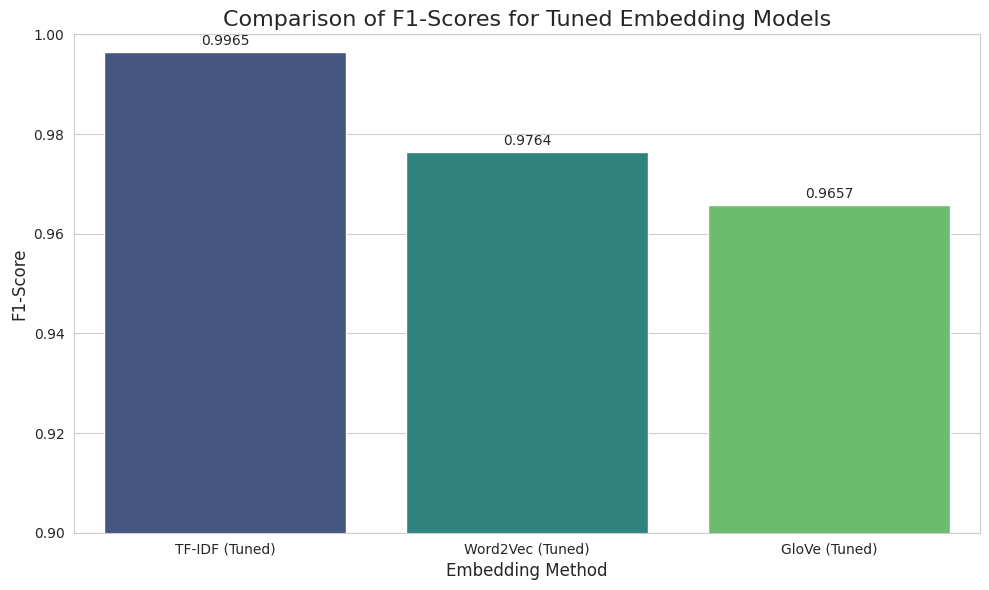

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Initialize the plot
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# 2. Create the bar plot using final_performance_df
ax = sns.barplot(
    x='Embedding Method',
    y='F1-Score',
    data=final_performance_df,
    palette='viridis',
    hue='Embedding Method',
    legend=False
)

# 3. Set y-axis limit to highlight differences
plt.ylim(0.90, 1.00)

# 4. Add title and labels
plt.title('Comparison of F1-Scores for Tuned Embedding Models', fontsize=16)
plt.xlabel('Embedding Method', fontsize=12)
plt.ylabel('F1-Score', fontsize=12)

# 5. Annotate bars with numerical values
for container in ax.containers:
    ax.bar_label(container, fmt='%.4f', padding=3)

# 6. Display the plot
plt.tight_layout()
plt.show()

#Comparative Confusion Matrix Analysis


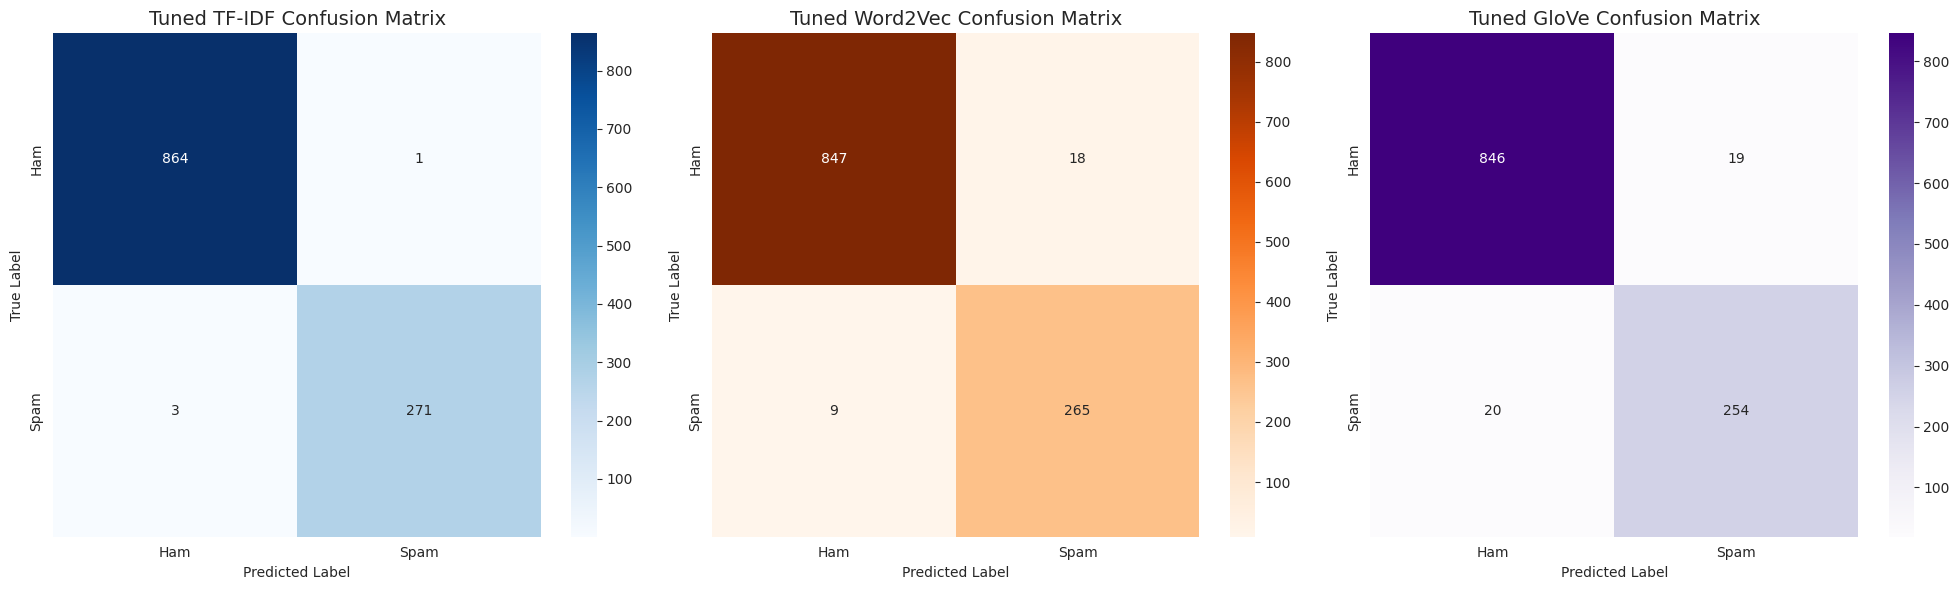

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Recompute Confusion Matrices for the Tuned Models
cm_tfidf_tuned = confusion_matrix(y_test, best_model_tfidf.predict(X_test_tfidf))
cm_w2v_tuned = confusion_matrix(y_test, best_model_w2v.predict(X_test_w2v))
cm_glove_tuned = confusion_matrix(y_test, best_model_glove.predict(X_test_glove))

# 2. Set up the plotting area (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# 3. Plot TF-IDF Confusion Matrix
sns.heatmap(cm_tfidf_tuned, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
axes[0].set_title('Tuned TF-IDF Confusion Matrix', fontsize=14)
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# 4. Plot Word2Vec Confusion Matrix
sns.heatmap(cm_w2v_tuned, annot=True, fmt='d', cmap='Oranges', ax=axes[1],
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
axes[1].set_title('Tuned Word2Vec Confusion Matrix', fontsize=14)
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

# 5. Plot GloVe Confusion Matrix
sns.heatmap(cm_glove_tuned, annot=True, fmt='d', cmap='Purples', ax=axes[2],
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
axes[2].set_title('Tuned GloVe Confusion Matrix', fontsize=14)
axes[2].set_xlabel('Predicted Label')
axes[2].set_ylabel('True Label')

# 6. Final adjustments and display
plt.tight_layout()
plt.show()

## Save and Download Trained Models

In this step, we will persist the tuned Logistic Regression models and the feature extraction components (TF-IDF vectorizer and Word2Vec model) to disk and download them as a zip archive.

In [26]:
import joblib
from google.colab import files
import os

# 1. Save TF-IDF Components
joblib.dump(best_model_tfidf, 'tfidf_lr_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

# 2. Save Word2Vec Components
joblib.dump(best_model_w2v, 'w2v_lr_model.pkl')
w2v_model.save('word2vec_model.bin')

# 3. Save GloVe Components
joblib.dump(best_model_glove, 'glove_lr_model.pkl')

# 4. Zip all models for easier download
!zip -r spam_classification_models.zip tfidf_lr_model.pkl tfidf_vectorizer.pkl w2v_lr_model.pkl word2vec_model.bin glove_lr_model.pkl

# 5. Download the archive
files.download('spam_classification_models.zip')

print("Models saved and download triggered.")

  adding: tfidf_lr_model.pkl (deflated 26%)
  adding: tfidf_vectorizer.pkl (deflated 57%)
  adding: w2v_lr_model.pkl (deflated 16%)
  adding: word2vec_model.bin (deflated 10%)
  adding: glove_lr_model.pkl (deflated 16%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Models saved and download triggered.
